# CIFAR-10 을 이용한 CNN 구축

## 필요 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
tf.__version__

'2.12.0'

## 로컬 GPU 장치 확인

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17953526157305727326
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18054449808667751068
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## 데이터 로드

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
print([x.shape for x in [x_train, y_train, x_test, y_test]])

[(50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1)]


In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 데이터 탐색 및 시각화

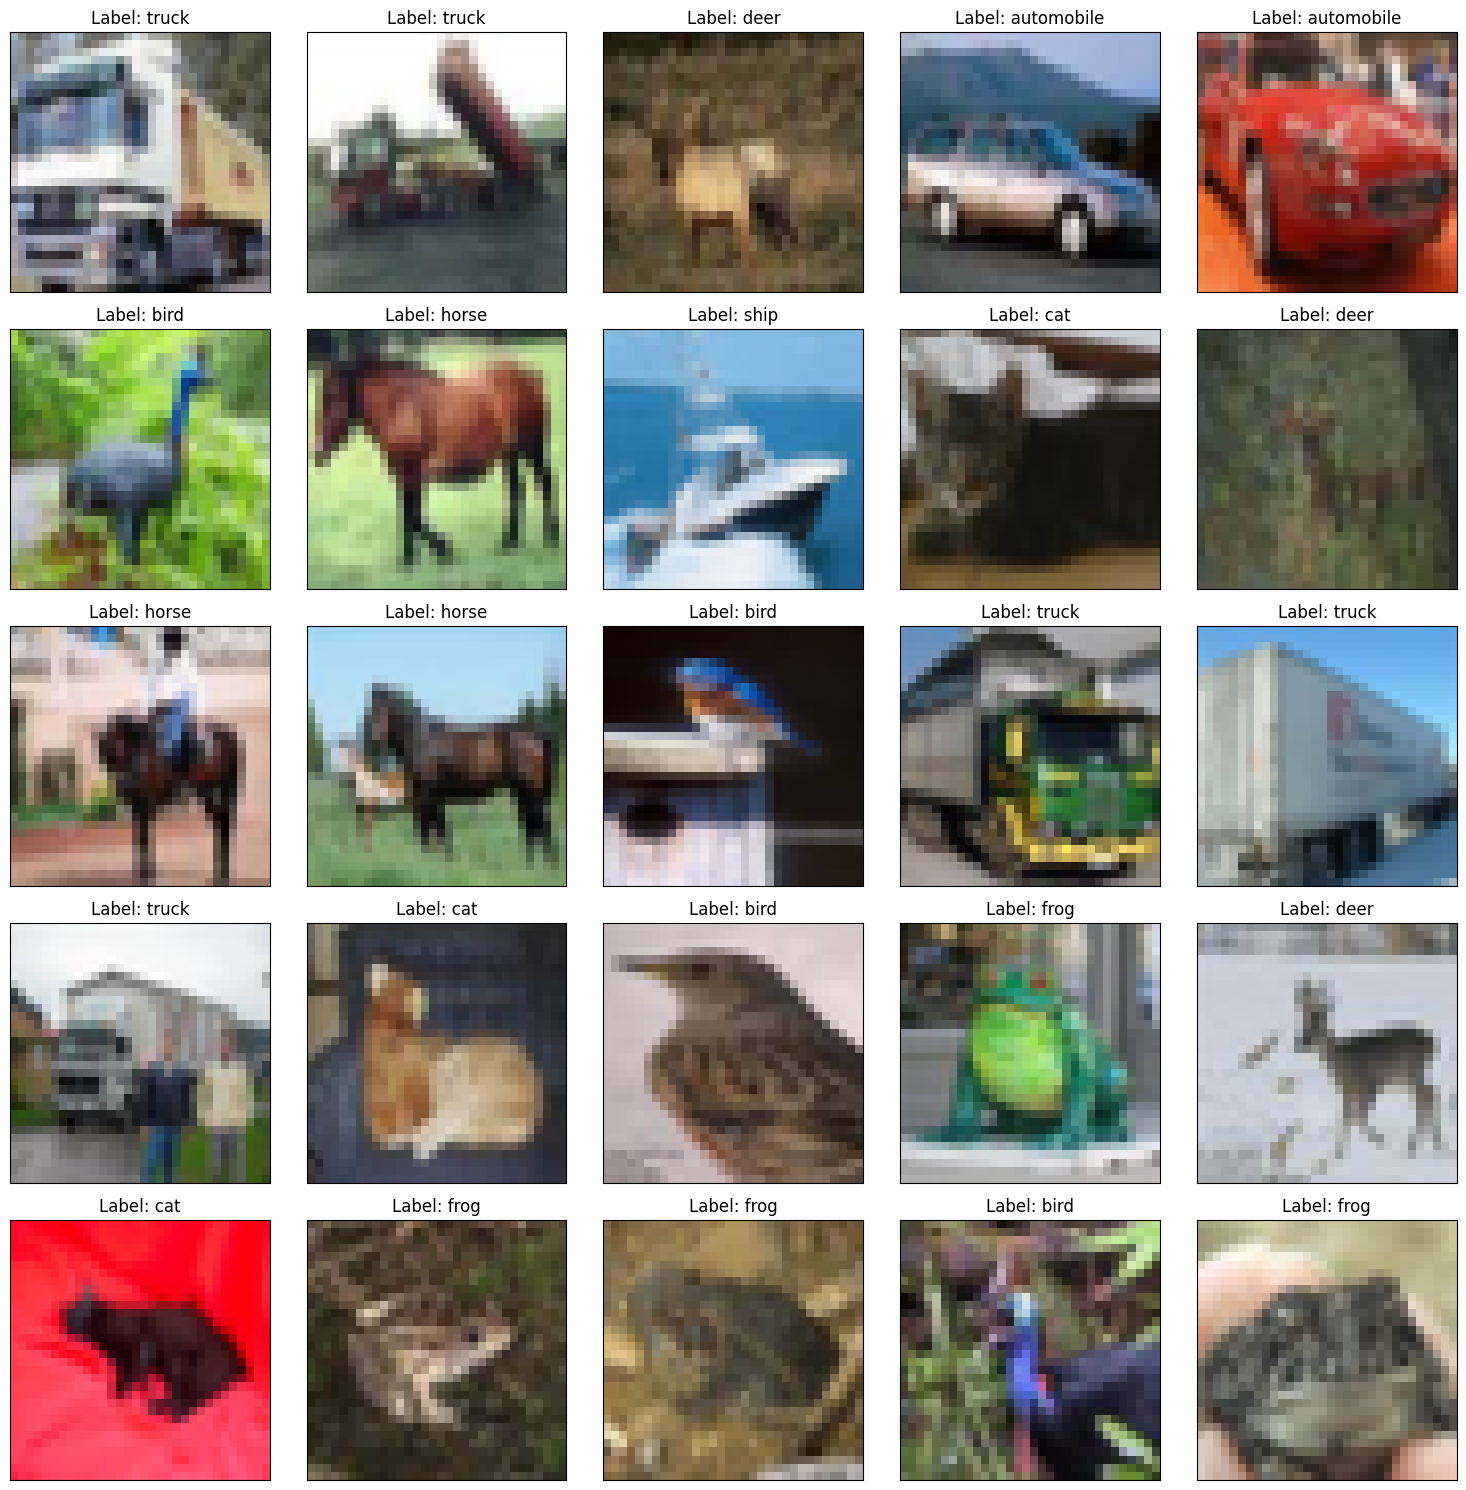

In [8]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Label: {class_names[y_train[i][0]]}')

plt.tight_layout()
plt.show()

## 데이터 전처리

### Data Scaling

In [9]:
x_train[0][9]

array([[154, 120,  89],
       [154, 112,  77],
       [156, 114,  82],
       [140, 100,  65],
       [123,  89,  53],
       [125,  86,  50],
       [126,  86,  48],
       [127,  91,  52],
       [133,  97,  60],
       [132,  97,  68],
       [ 90,  60,  30],
       [ 63,  35,   9],
       [ 62,  33,  16],
       [ 70,  39,  20],
       [ 79,  50,  30],
       [103,  53,  26],
       [152,  70,  33],
       [148,  64,  37],
       [141,  79,  61],
       [121,  75,  57],
       [101,  58,  41],
       [ 96,  54,  33],
       [ 86,  48,  24],
       [ 75,  38,  21],
       [101,  63,  32],
       [136,  91,  53],
       [136,  92,  53],
       [134,  93,  50],
       [133,  93,  52],
       [132,  93,  52],
       [128,  86,  45],
       [133,  92,  55]], dtype=uint8)

In [10]:
x_train_scaled = x_train / 255.0
x_test_scaled = x_test / 255.0

In [11]:
x_train_scaled[0][9]

array([[0.60392157, 0.47058824, 0.34901961],
       [0.60392157, 0.43921569, 0.30196078],
       [0.61176471, 0.44705882, 0.32156863],
       [0.54901961, 0.39215686, 0.25490196],
       [0.48235294, 0.34901961, 0.20784314],
       [0.49019608, 0.3372549 , 0.19607843],
       [0.49411765, 0.3372549 , 0.18823529],
       [0.49803922, 0.35686275, 0.20392157],
       [0.52156863, 0.38039216, 0.23529412],
       [0.51764706, 0.38039216, 0.26666667],
       [0.35294118, 0.23529412, 0.11764706],
       [0.24705882, 0.1372549 , 0.03529412],
       [0.24313725, 0.12941176, 0.0627451 ],
       [0.2745098 , 0.15294118, 0.07843137],
       [0.30980392, 0.19607843, 0.11764706],
       [0.40392157, 0.20784314, 0.10196078],
       [0.59607843, 0.2745098 , 0.12941176],
       [0.58039216, 0.25098039, 0.14509804],
       [0.55294118, 0.30980392, 0.23921569],
       [0.4745098 , 0.29411765, 0.22352941],
       [0.39607843, 0.22745098, 0.16078431],
       [0.37647059, 0.21176471, 0.12941176],
       [0.

### Label One-Hot Encoding

In [12]:
print([x.shape for x in [y_train, y_test]])

[(50000, 1), (10000, 1)]


In [13]:
y_train_onehot = tf.keras.utils.to_categorical(y_train).astype('int')
y_test_onehot = tf.keras.utils.to_categorical(y_test).astype('int')

In [14]:
print([x.shape for x in [y_train_onehot, y_test_onehot]])

[(50000, 10), (10000, 10)]


### Data Shuffling 및 Batch

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train_onehot)).shuffle(10000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test_onehot)).shuffle(10000).batch(64)

In [16]:
for X, Y in train_ds.take(1):
    print(X.shape, Y.shape)

(64, 32, 32, 3) (64, 10)


## 모델링

### LeNet 모델 구성

In [17]:
model = tf.keras.models.Sequential()

# Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=(32,32,3)))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

# Fully Connected Layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 activation (Activation)     (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0         
                                                        

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### 모델 학습

In [19]:
history = model.fit(train_ds, epochs=5, validation_data=test_ds, shuffle=True)

Epoch 1/5
782/782 [==============================] - 13s 9ms/step - loss: 1.6885 - accuracy: 0.3799 - val_loss: 1.3652 - val_accuracy: 0.5085
Epoch 2/5
782/782 [==============================] - 5s 7ms/step - loss: 1.3417 - accuracy: 0.5173 - val_loss: 1.1227 - val_accuracy: 0.6042
Epoch 3/5
782/782 [==============================] - 7s 8ms/step - loss: 1.1938 - accuracy: 0.5753 - val_loss: 1.0773 - val_accuracy: 0.6292
Epoch 4/5
782/782 [==============================] - 8s 10ms/step - loss: 1.1085 - accuracy: 0.6078 - val_loss: 0.9634 - val_accuracy: 0.6539
Epoch 5/5
782/782 [==============================] - 8s 10ms/step - loss: 1.0449 - accuracy: 0.6306 - val_loss: 0.9238 - val_accuracy: 0.6782


### 모델 평가

In [20]:
model.metrics_names

['loss', 'accuracy']

In [21]:
scores = model.evaluate(test_ds)

157/157 [==============================] - 1s 6ms/step - loss: 0.9238 - accuracy: 0.6782


In [22]:
print(f'Model Loss=     {scores[0]:,.4f}')
print(f'Model Accuracy= {scores[1]:,.4f}')

Model Loss=     0.9238
Model Accuracy= 0.6782


### 모델 예측

In [23]:
y_pred = model.predict(x_test_scaled).argmax(axis=1)

313/313 [==============================] - 1s 3ms/step


In [24]:
y_pred.shape, y_test.shape

((10000,), (10000, 1))

In [25]:
y_true = y_test.ravel()

In [26]:
y_true.shape

(10000,)

### 모델 예측 평가

In [27]:
cm = confusion_matrix(y_true, y_pred)

In [28]:
cm

array([[728,  39,  40,  21,   8,   8,  10,  17,  89,  40],
       [ 13, 898,   1,  12,   4,   8,  10,   2,  16,  36],
       [ 98,   6, 487,  89,  96,  94,  59,  39,  21,  11],
       [ 30,  15,  64, 488,  47, 221,  74,  35,  12,  14],
       [ 40,   7,  72,  93, 551,  49,  68, 103,  15,   2],
       [ 24,  11,  47, 158,  32, 632,  29,  53,   9,   5],
       [  4,   6,  30,  78,  47,  31, 787,  10,   5,   2],
       [ 19,   4,  33,  48,  41,  84,   5, 755,   1,  10],
       [ 72,  71,  11,  25,   1,   9,   4,   7, 777,  23],
       [ 25, 192,   4,  25,   4,   9,  15,  18,  29, 679]])

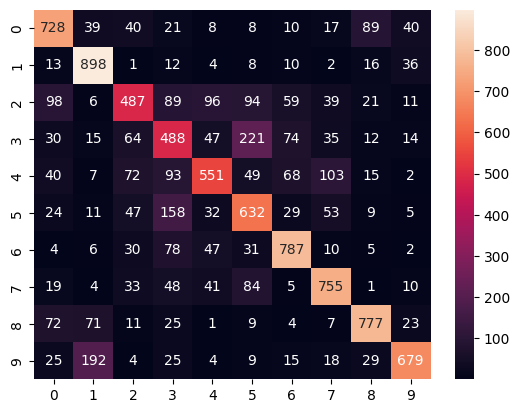

In [29]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [30]:
print(f'Accuracy  Score= {accuracy_score(y_true, y_pred):,.4f}')
print(f'Precision Score= {precision_score(y_true, y_pred, average="macro"):,.4f}')
print(f'Recall    Score= {recall_score(y_true, y_pred, average="macro"):,.4f}')
print(f'F1        Score= {f1_score(y_true, y_pred, average="macro"):,.4f}')

Accuracy  Score= 0.6782
Precision Score= 0.6805
Recall    Score= 0.6782
F1        Score= 0.6759


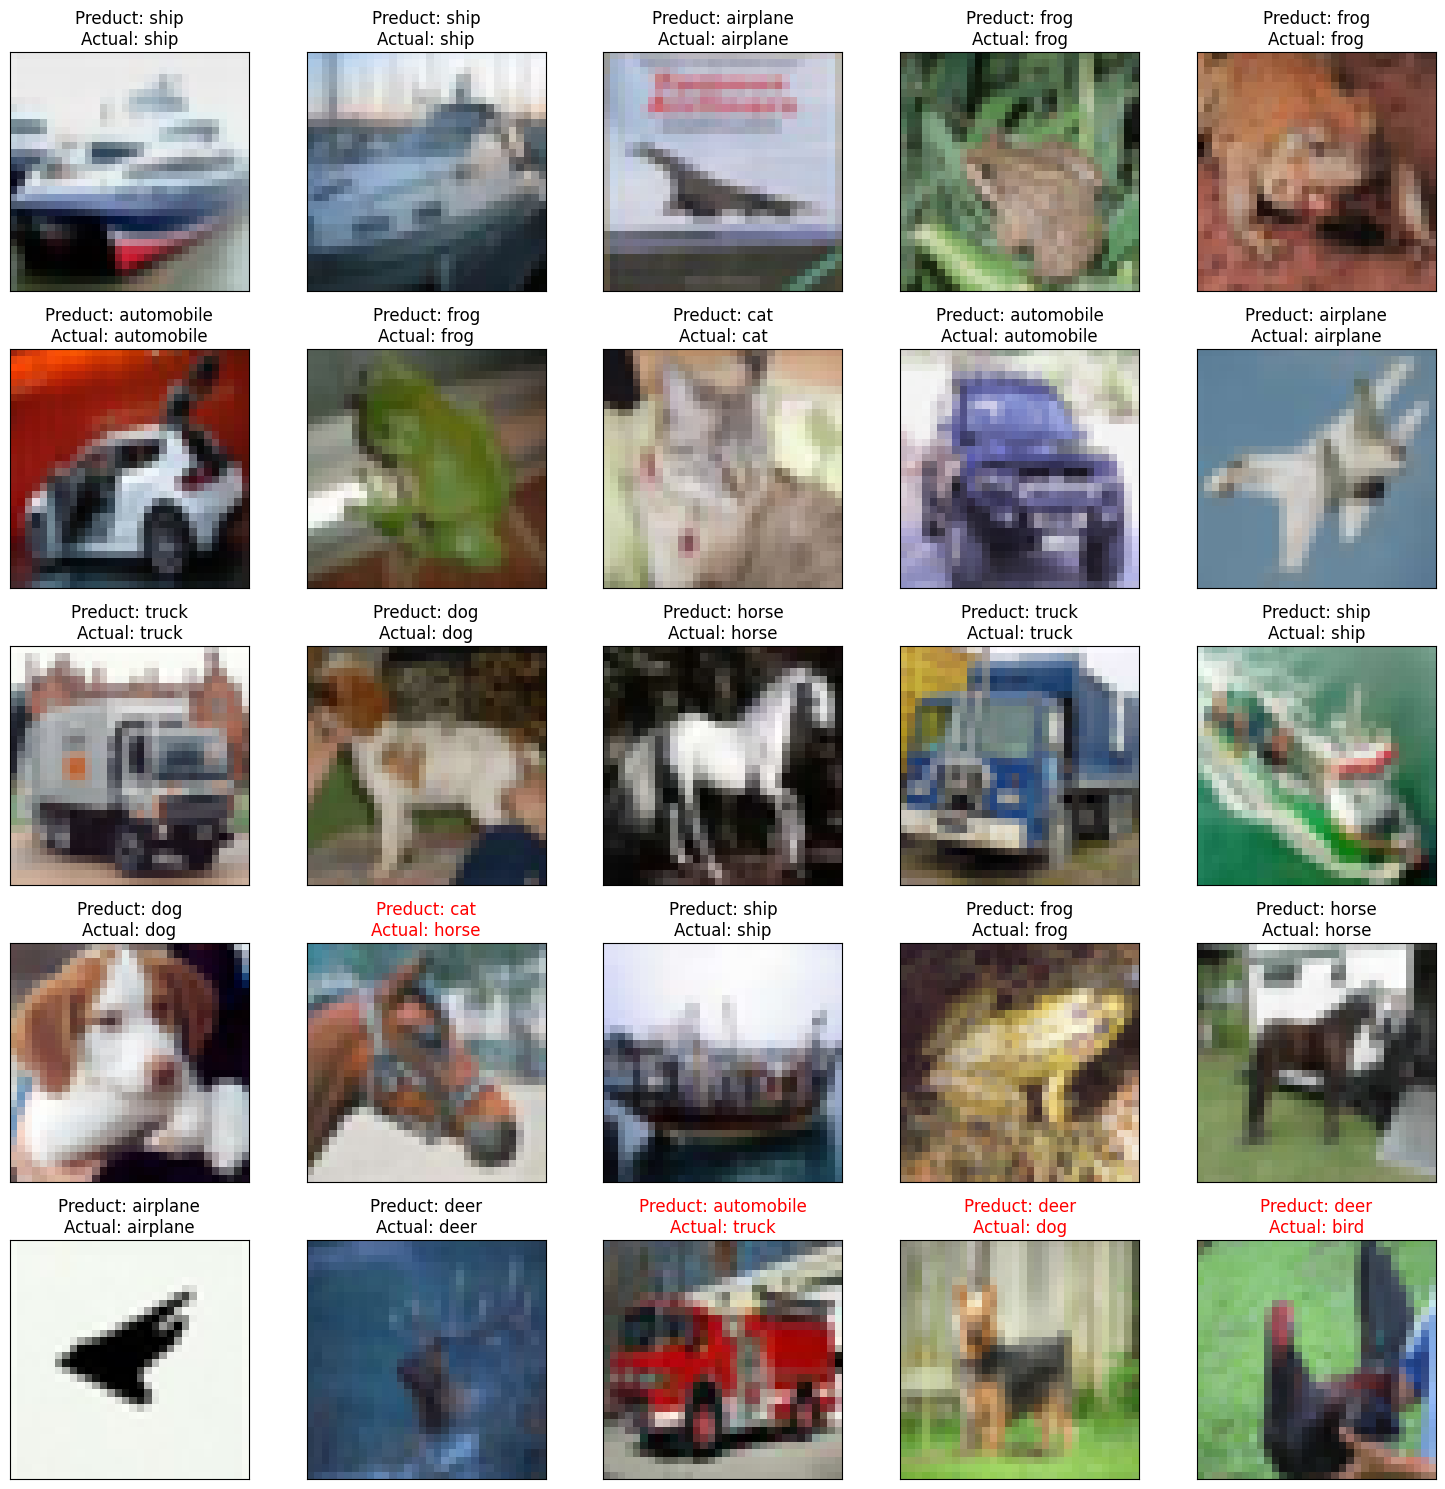

In [31]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(x_test[i])
    plt.xticks([])
    plt.yticks([])

    color = 'black'
    if y_true[i] != y_pred[i]:
        color = 'red'
    plt.title(f'Preduct: {class_names[y_pred[i]]}\nActual: {class_names[y_true[i]]}', color=color)

plt.tight_layout()
plt.show()

# 실습 : Convolutional Layer 와 Pooling Layer 를  추가하고 Hyper-parameter 조정하여 성능 개선 혹은 epochs 늘려서 accuracy 향상 비교

In [36]:
del model
del history

NameError: ignored

## Convolutional Layer 및 Pooling Layer 추가

In [37]:
model = tf.keras.models.Sequential()

# Convolutional Layer
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=(32,32,3)))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(tf.keras.layers.Activation(activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.2))


# Fully Connected Layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 activation_7 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 activation_8 (Activation)   (None, 16, 16, 32)        0         
                                                      

## Hyper Parameter 조정

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Epoch 증가

In [39]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
782/782 [==============================] - 8s 8ms/step - loss: 1.8597 - accuracy: 0.3005 - val_loss: 1.4459 - val_accuracy: 0.4746
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 1.4836 - accuracy: 0.4615 - val_loss: 1.2720 - val_accuracy: 0.5409
Epoch 3/10
782/782 [==============================] - 5s 7ms/step - loss: 1.3215 - accuracy: 0.5273 - val_loss: 1.1044 - val_accuracy: 0.6130
Epoch 4/10
782/782 [==============================] - 6s 8ms/step - loss: 1.2340 - accuracy: 0.5602 - val_loss: 1.0508 - val_accuracy: 0.6315
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 1.1670 - accuracy: 0.5888 - val_loss: 1.0043 - val_accuracy: 0.6490
Epoch 6/10
782/782 [==============================] - 6s 8ms/step - loss: 1.1167 - accuracy: 0.6091 - val_loss: 0.9597 - val_accuracy: 0.6636
Epoch 7/10
782/782 [==============================] - 8s 10ms/step - loss: 1.0803 - accuracy: 0.6229 - val_loss: 0.9464 - val_accuracy: 0.6706
Epoch

## 변경된 모델 평가

In [40]:
scores = model.evaluate(test_ds)

157/157 [==============================] - 1s 4ms/step - loss: 0.8856 - accuracy: 0.6949


In [41]:
print(f'Model Loss=     {scores[0]:,.4f}')
print(f'Model Accuracy= {scores[1]:,.4f}')

Model Loss=     0.8856
Model Accuracy= 0.6949


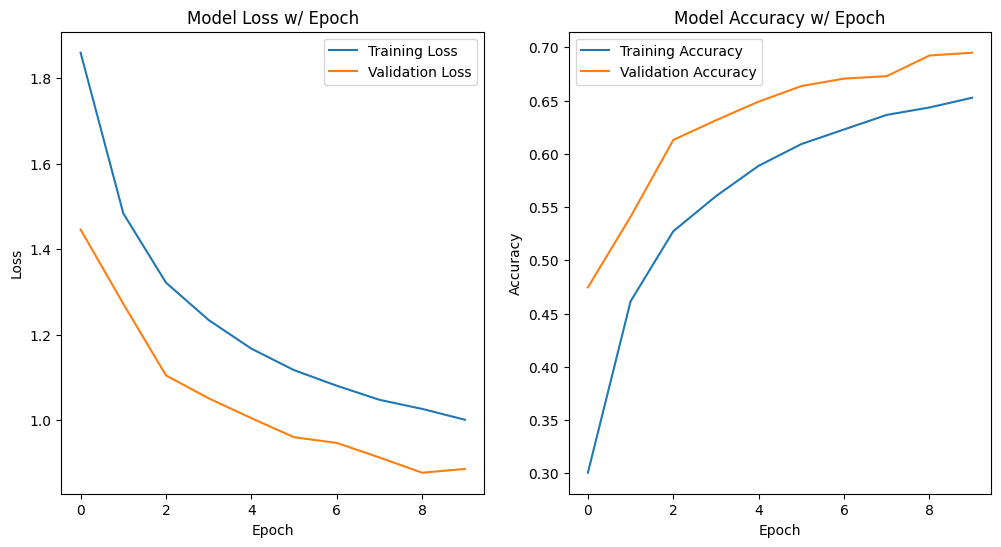

In [42]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss w/ Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy w/ Epoch')

plt.show()

In [43]:
y_pred = model.predict(x_test_scaled).argmax(axis=1)

313/313 [==============================] - 1s 2ms/step


In [44]:
y_true = y_test.ravel()

In [45]:
cm = confusion_matrix(y_true, y_pred)

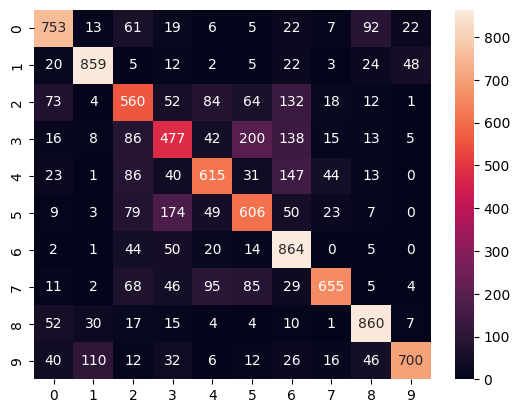

In [46]:
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [47]:
print(f'Accuracy  Score= {accuracy_score(y_true, y_pred):,.4f}')
print(f'Precision Score= {precision_score(y_true, y_pred, average="macro"):,.4f}')
print(f'Recall    Score= {recall_score(y_true, y_pred, average="macro"):,.4f}')
print(f'F1        Score= {f1_score(y_true, y_pred, average="macro"):,.4f}')

Accuracy  Score= 0.6949
Precision Score= 0.7040
Recall    Score= 0.6949
F1        Score= 0.6945


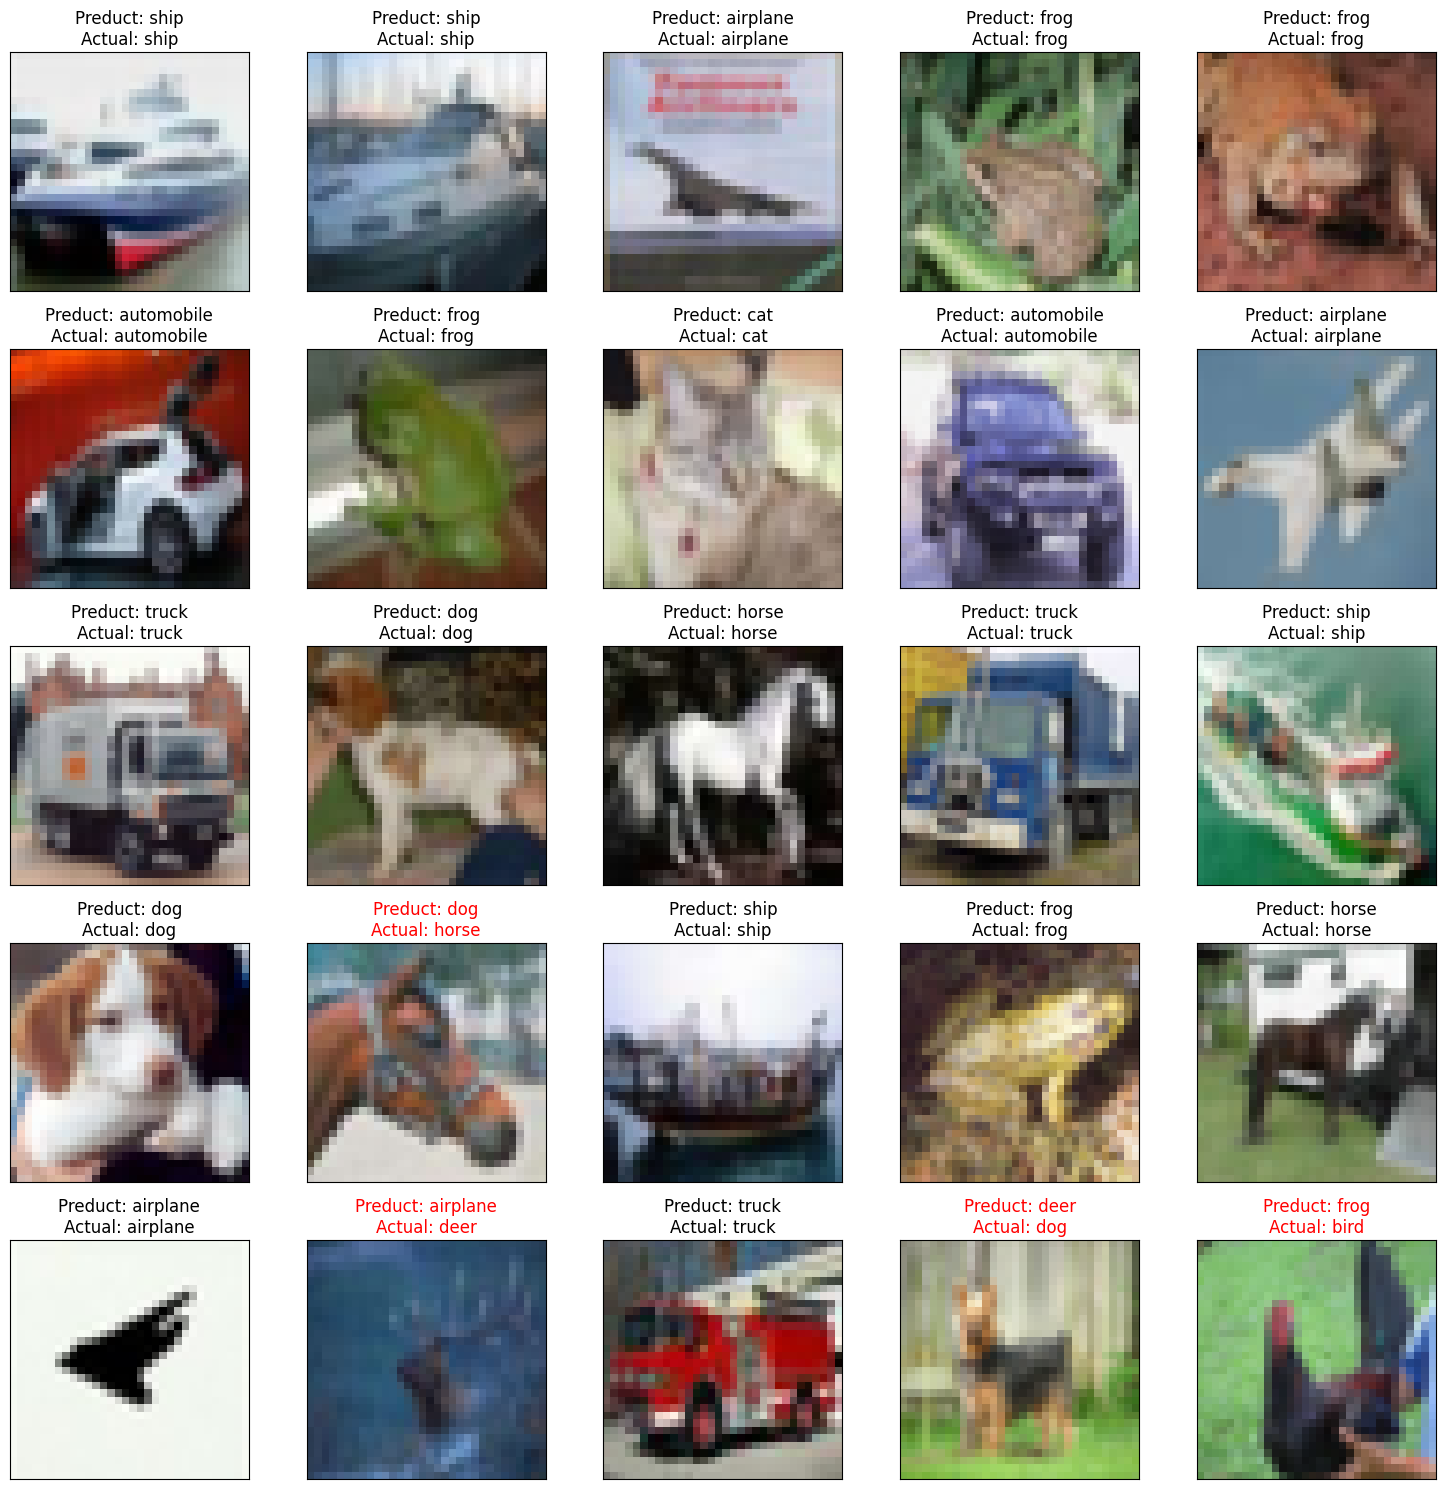

In [48]:
plt.figure(figsize=(15, 15))

for i in range(1, 26):
    plt.subplot(5,5,i)
    plt.imshow(x_test[i])
    plt.xticks([])
    plt.yticks([])

    color = 'black'
    if y_true[i] != y_pred[i]:
        color = 'red'
    plt.title(f'Preduct: {class_names[y_pred[i]]}\nActual: {class_names[y_true[i]]}', color=color)

plt.tight_layout()
plt.show()